# Time Series Classification and Clustering Assignment

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans

### Import the Walmart stock price data set (WMT_data.csv).

In [2]:
df = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/Data%20Sets%20Time%20Series%20Analysis/Time%20Series%20-%20Day%205/WMT_data.csv')
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,71.20,71.64,71.070,71.48,5906823,WMT
1,2013-02-11,71.25,71.51,70.530,71.40,6202534,WMT
2,2013-02-12,71.49,71.66,71.100,71.40,4761910,WMT
3,2013-02-13,71.29,71.70,71.210,71.39,3969807,WMT
4,2013-02-14,71.10,71.23,70.755,70.82,6820952,WMT


In [3]:
df['date'] = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1259 non-null   datetime64[ns]
 1   open    1259 non-null   float64       
 2   high    1259 non-null   float64       
 3   low     1259 non-null   float64       
 4   close   1259 non-null   float64       
 5   volume  1259 non-null   int64         
 6   Name    1259 non-null   object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 69.0+ KB


### Transform the data to be able to predict minor direction changes in the stock's price, given 180 days of history.

- Remember to calculate daily returns from the observed values (closing price).
- Make the critera for identifying a direction change when the observed values (closing price) cross the 5 day moving average.
- Create a binary column that defaults to 0 unless the criteria is met (then updates to 1).
- Shift the data set so that you have 180 days of history for each record.

In [4]:
df['Returns'] = df['close'].pct_change()
df['5MA'] = df['close'].rolling(5).mean()

df['Trend'] = 'None'
df.loc[(df['close'] < df['5MA']), 'Trend']=='Negative'
df.loc[(df['close'] > df['5MA']), 'Trend']=='Positive'
df['Change'] = df['Trend'].eq(df['Trend'].shift())

df['Binary'] = 0
df['Binary'] = np.where(df['close'] > df['5MA'], df['Binary'], 1)

df.dropna(inplace = True)
df.drop(df.index[0], inplace = True)

In [5]:
df.Binary.value_counts()

0    684
1    570
Name: Binary, dtype: int64

In [6]:
tf_df = df[['date', 'Returns', 'Binary']]
history = 180
future = 0
shifts = [x + future for x in list(range(1, history +1))]
for shift in shifts:
    tf_df['t-'+str(shift)]=tf_df['Returns'].shift(shift)
tf_df.dropna(inplace = True)

tf_df.head()

C:\Users\jonat\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,date,Returns,Binary,t-1,t-2,t-3,t-4,t-5,t-6,t-7,...,t-171,t-172,t-173,t-174,t-175,t-176,t-177,t-178,t-179,t-180
185,2013-11-01,0.004169,0,-0.002080,-0.001947,-0.001037,0.013933,-0.004449,0.006851,-0.005503,...,0.013563,-0.012280,0.007734,0.009512,0.000568,0.001993,0.015171,0.006545,-0.007792,-0.021463
186,2013-11-04,0.003374,0,0.004169,-0.002080,-0.001947,-0.001037,0.013933,-0.004449,0.006851,...,0.021188,0.013563,-0.012280,0.007734,0.009512,0.000568,0.001993,0.015171,0.006545,-0.007792
187,2013-11-05,0.001164,0,0.003374,0.004169,-0.002080,-0.001947,-0.001037,0.013933,-0.004449,...,0.006279,0.021188,0.013563,-0.012280,0.007734,0.009512,0.000568,0.001993,0.015171,0.006545
188,2013-11-06,0.009558,0,0.001164,0.003374,0.004169,-0.002080,-0.001947,-0.001037,0.013933,...,-0.004612,0.006279,0.021188,0.013563,-0.012280,0.007734,0.009512,0.000568,0.001993,0.015171
189,2013-11-07,-0.008316,0,0.009558,0.001164,0.003374,0.004169,-0.002080,-0.001947,-0.001037,...,-0.000818,-0.004612,0.006279,0.021188,0.013563,-0.012280,0.007734,0.009512,0.000568,0.001993


### Train a Logistic Regression classification model on the transformed data.

In [7]:
model = LogisticRegression(class_weight = 'balanced')

In [8]:
x = tf_df.drop(['date', 'Returns', 'Binary'], axis = 1)
y = tf_df['Binary']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .2, random_state = 69, shuffle = False)
model.fit(x_train, y_train)
pred = model.predict(x_test)

### Run a classification report and evaluate the performance of the classifier.

In [9]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.77      0.69      0.73       133
           1       0.57      0.67      0.62        82

    accuracy                           0.68       215
   macro avg       0.67      0.68      0.67       215
weighted avg       0.70      0.68      0.69       215



### Transform the data again to have 10 days of history for clustering.

In [10]:
tf_df = df[['date', 'Returns', 'Binary']]
history = 10
future = 0
shifts = [x + future for x in list(range(1, history +1))]
for shift in shifts:
    tf_df['t-'+str(shift)]=tf_df['Returns'].shift(shift)
tf_df.dropna(inplace = True)


C:\Users\jonat\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [11]:
x_df = pd.DataFrame(x_train)
x_df.head()

,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10,...,t-171,t-172,t-173,t-174,t-175,t-176,t-177,t-178,t-179,t-180
185,-0.002080,-0.001947,-0.001037,0.013933,-0.004449,0.006851,-0.005503,0.015569,-0.007397,-0.000924,...,0.013563,-0.012280,0.007734,0.009512,0.000568,0.001993,0.015171,0.006545,-0.007792,-0.021463
186,0.004169,-0.002080,-0.001947,-0.001037,0.013933,-0.004449,0.006851,-0.005503,0.015569,-0.007397,...,0.021188,0.013563,-0.012280,0.007734,0.009512,0.000568,0.001993,0.015171,0.006545,-0.007792
187,0.003374,0.004169,-0.002080,-0.001947,-0.001037,0.013933,-0.004449,0.006851,-0.005503,0.015569,...,0.006279,0.021188,0.013563,-0.012280,0.007734,0.009512,0.000568,0.001993,0.015171,0.006545
188,0.001164,0.003374,0.004169,-0.002080,-0.001947,-0.001037,0.013933,-0.004449,0.006851,-0.005503,...,-0.004612,0.006279,0.021188,0.013563,-0.012280,0.007734,0.009512,0.000568,0.001993,0.015171
189,0.009558,0.001164,0.003374,0.004169,-0.002080,-0.001947,-0.001037,0.013933,-0.004449,0.006851,...,-0.000818,-0.004612,0.006279,0.021188,0.013563,-0.012280,0.007734,0.009512,0.000568,0.001993


### Train a K Means clustering model on the data. 

Try different values for K and see how the summary changes.

In [12]:
clusters = range(2,6)


for cluster in clusters:
    model = KMeans(n_clusters = cluster, random_state = 69)
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    print(f'For {cluster} clusters, it is: ','\n' ,classification_report(y_test, pred))

For 2 clusters, it is:  
               precision    recall  f1-score   support

           0       0.71      0.08      0.14       133
           1       0.39      0.95      0.55        82

    accuracy                           0.41       215
   macro avg       0.55      0.51      0.34       215
weighted avg       0.59      0.41      0.29       215

For 3 clusters, it is:  
               precision    recall  f1-score   support

           0       0.65      0.41      0.50       133
           1       0.32      0.27      0.29        82
           2       0.00      0.00      0.00         0

    accuracy                           0.36       215
   macro avg       0.32      0.23      0.27       215
weighted avg       0.52      0.36      0.42       215



C:\Users\jonat\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jonat\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jonat\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


For 4 clusters, it is:  
               precision    recall  f1-score   support

           0       0.70      0.29      0.41       133
           1       0.41      0.24      0.31        82
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0

    accuracy                           0.27       215
   macro avg       0.28      0.13      0.18       215
weighted avg       0.59      0.27      0.37       215

For 5 clusters, it is:  
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       133
           1       0.34      0.24      0.29        82
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0

    accuracy                           0.09       215
   macro avg       0.07      0.05      0.06       215
weighted avg       0.13      0.09      0.11       215



C:\Users\jonat\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Visualize the summary of the clustering results as a heatmap.

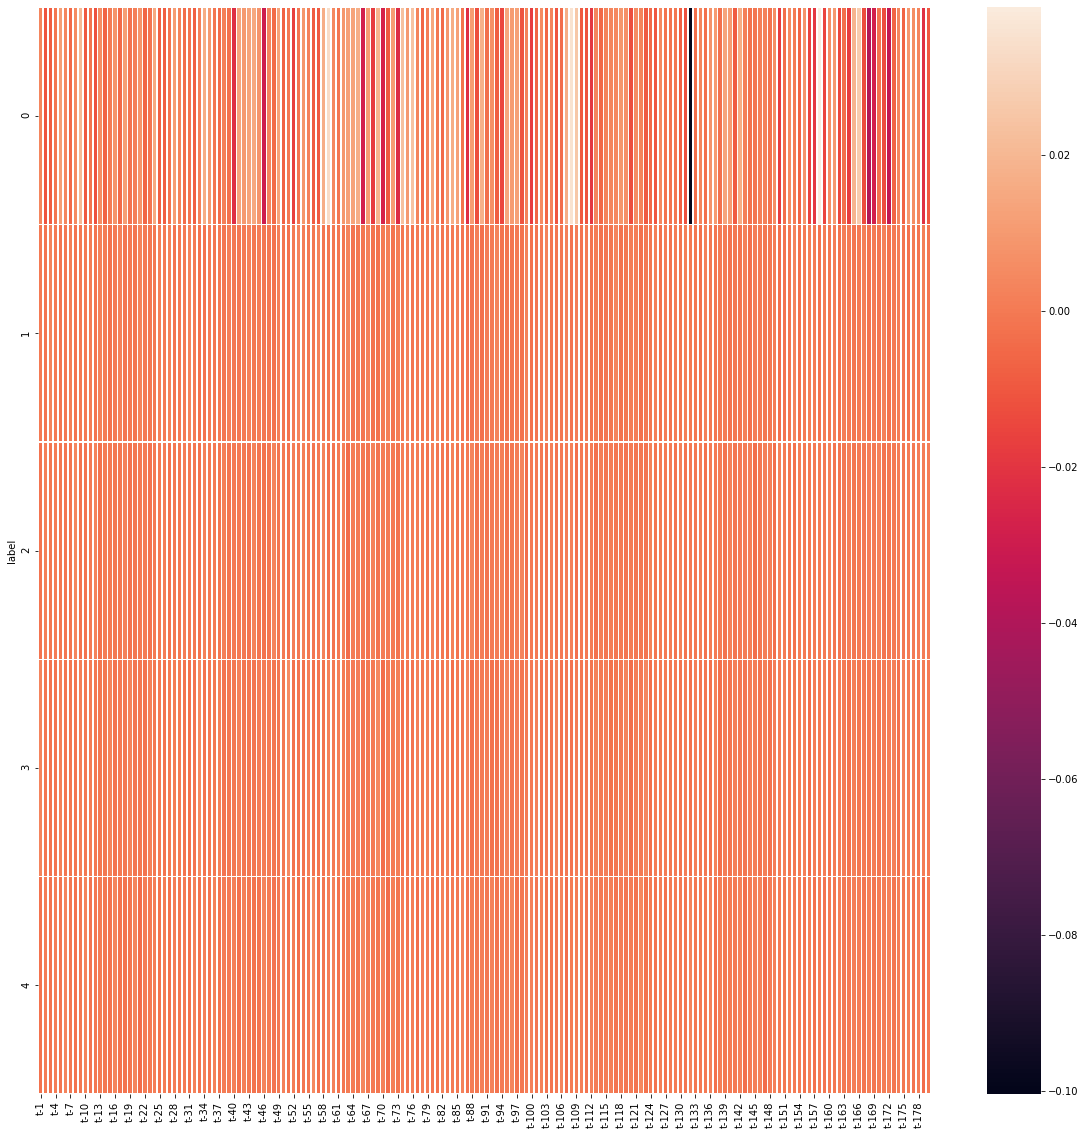

In [18]:
model = KMeans(n_clusters = cluster, random_state = 69)
model.fit(x_train, y_train)
labels = model.labels_
x_df['label'] = model.labels_


fig, ax = plt.subplots(figsize = (20,20))
sns.heatmap(x_df.groupby(by = 'label').mean(), linewidths = .5, ax = ax)

# I feel like we should be looking into other methods and feature engineering like umap and random forest for better analysis of actual stock predictive values, but eh, I'm a noob